# Building LSH Indexers for Low-Latency Embedding Retrieval

This notebook accompanies the blog post "Latency optimized embedding retrieval with Learnable LSH and Quantization". It demonstrates the implementation of various LSH-based indexing strategies for fast, memory-efficient embedding retrieval.

## Overview
We'll implement three flavors of LSH indexers along with the supporting components:
* Simple LSH Indexer - Uses random projections for hashing
* Learned LSH Indexer - Uses a trainable neural network for hash function generation
* Multi-Index LSH - Divides hash codes into multiple parts for higher recall

We'll also cover:

    Training the hash function
    Quantization techniques
    Evaluation methodologies



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random, math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os, psutil
from tqdm.notebook import tqdm
from collections import defaultdict
import time
from datasets import load_dataset
from sentence_transformers import SentenceTransformer


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / 1024 / 1024  # Convert bytes to MB

# Custom dataset for triplet learning
class ParagraphTripletDataset(Dataset):
    def __init__(self, docs, model_name, device, seed=42):
        self.device = device
        self.paragraphs = [d['text'] for d in docs]
        self.model = SentenceTransformer(model_name, device=device)
        self.model.eval()
        print("Encoding paragraphs...")
        self.embeddings = self.model.encode(self.paragraphs, convert_to_tensor=True)
        embed_np = self.embeddings.cpu().numpy()
        self.cluster_to_idx = {}
        for i, doc in enumerate(docs):
            self.cluster_to_idx.setdefault(doc["label"], []).append(i)
    
    def __len__(self):
        return len(self.paragraphs)

    def __getitem__(self, index):
        valid_clusters = []
        for c, idxs in self.cluster_to_idx.items():
            if index in idxs:
                valid_clusters.append(c)
                break
        
        # Select something that has at least 2 docs
        valid_clusters = [c for c, idxs in self.cluster_to_idx.items() if len(idxs) > 1]
        assert len(valid_clusters) > 0

        anchor = random.choice(valid_clusters)
        if len(self.cluster_to_idx[anchor]) > 1:
            anchor_idx, positive_idx = random.sample(self.cluster_to_idx[anchor], 2)
        else:
            anchor_idx = positive_idx = self.cluster_to_idx[anchor][0]

        other_clusters = [c for c in self.cluster_to_idx.keys() if c != anchor]
        assert len(other_clusters) > 0
                          
        negative_cluster = random.choice(other_clusters)
        negative_idx = random.choice(self.cluster_to_idx[negative_cluster])
            
        anchor_emb = self.embeddings[anchor_idx]
        positive_emb = self.embeddings[positive_idx]
        negative_emb = self.embeddings[negative_idx]
       
        return anchor_emb, positive_emb, negative_emb

# LearnedHasher model
class LearnedHasher(nn.Module):
    def __init__(self, input_dim, hash_dim):
        super(LearnedHasher, self).__init__()
        self.fc = nn.Linear(input_dim, hash_dim)

    def forward(self, x):
        logits = self.fc(x)
        return torch.tanh(logits)

    def binary_hash(self, x):
        continuous = self.forward(x)
        return (continuous > 0).int()

# Training function
def train(model, dataloader, epochs=2, lr=1e-3, margin=1.0, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.TripletMarginLoss(margin=margin, p=2)

    for e in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (anchor, positive, negative) in enumerate(tqdm(dataloader, desc=f"Epoch {e+1}/{epochs}")):
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f"Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}")
                
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {e+1} Loss: {avg_loss:.4f}")
    return model


def hamming_distance_basic(k1, k2):
    return sum(c1 != c2 for c1, c2 in zip(k1, k2))

#optimzied
def hamming_distance(key1, key2):
    # Convert binary strings to integers
    int1 = int(key1, 2)
    int2 = int(key2, 2)
    
    xor_result = int1 ^ int2     # XOR gives bits that differ
    
    count = 0
    while xor_result: # count the number of set bits (Brian Kernighan's algorithm) https://www.geeksforgeeks.org/count-set-bits-in-an-integer/
        xor_result &= (xor_result - 1)  # Clear the least significant bit set
        count += 1
    return count

def chunk_hamming_distance(key1, key2, chunk_size=32):

    if len(key1) != len(key2):
        raise ValueError("Keys must be of equal length")
    
    distance = 0
    for i in range(0, len(key1), chunk_size):
        chunk1 = key1[i:i + chunk_size]
        chunk2 = key2[i:i + chunk_size]
        
        # Count differing bits in this chunk
        for j in range(len(chunk1)):
            if chunk1[j] != chunk2[j]:
                distance += 1
                
    return distance

def batch_chunk_hamming_distances(query_key, all_keys):
    distances = np.zeros(len(all_keys), dtype=np.int32)
    
    for i, key in enumerate(all_keys):     # character-wise comparison
        dist = 0
        for j in range(min(len(query_key), len(key))):
            if query_key[j] != key[j]:
                dist += 1
        distances[i] = dist
        
    return distances

def split_binary_key(binary_key, num_parts):
    key_len = len(binary_key)
    part_size = math.floor(key_len / num_parts)
    parts = []
    start = 0
    for i in range(num_parts):
        if i == num_parts - 1:
            parts.append(binary_key[start:])
        else:
            parts.append(binary_key[start:start + part_size])
            start += part_size
    return parts

class NaiveQuantizer:
    def __init__(self, scale=127.0):
        self.scale = scale
    
    def quantize(self, x):
        x_c = torch.clamp(x, -1, 1)
        q = torch.round(x_c * self.scale).to(torch.int8)
        return q
    
    def dequantize(self, q):
        return q.to(torch.float32) / self.scale



class SimpleLSHIndexer:
    def __init__(self, num_h, dim):
        self.num_h = num_h
        self.dim = dim
        self.planes = np.random.randn(num_h, dim)
        self.hash_t = {}
        self.vectors = []  # Store vectors for memory measurement

    def hash_vector(self, vector):
        vector_np = vector.cpu().squeeze().numpy()
        projection = np.dot(self.planes, vector_np)
        bits = (projection > 0).astype(int)
        hash_code = ''.join(bits.astype(str))
        return hash_code

    def index(self, vector, doc_id):
        hash_code = self.hash_vector(vector)
        if hash_code not in self.hash_t:
            self.hash_t[hash_code] = []
        self.hash_t[hash_code].append((doc_id, vector))
        self.vectors.append(vector)  # Store for memory measurement

    def query(self, vector, top_k=5, neighbors=1):
        start_time = time.time()
        hash_code = self.hash_vector(vector)
        candidates = []
        if neighbors == 1:
            candidates = self.hash_t.get(hash_code, [])
        else:
            distances = [(bk, hamming_distance(hash_code, bk)) for bk in list(self.hash_t.keys())]
            distances.sort(key=lambda x: x[1])  # sort by asc 
            for bk, d in distances[:neighbors]:
                if bk in self.hash_t:  
                    candidates.extend(self.hash_t[bk])
        
        if not candidates:
            query_time = time.time() - start_time
            return [], query_time

        # rerank 
        def cosine_similarity(a, b):
            a_np = a.cpu().numpy() if isinstance(a, torch.Tensor) else a
            b_np = b.cpu().numpy() if isinstance(b, torch.Tensor) else b
            return np.dot(a_np, b_np) / (np.linalg.norm(a_np) * np.linalg.norm(b_np))

        sims = []
        for c_id, c_vector in candidates:
            sims.append((c_id, cosine_similarity(vector, c_vector)))
        sims.sort(key=lambda x: x[1], reverse=True)
        
        query_time = time.time() - start_time
        return sims[:top_k], query_time

    def get_memory_usage_mb(self):
        mem_usage = 0
        for k, v in self.hash_t.items():
            mem_usage += len(k) + 16  # key length + pointer overhead
            # List overhead + each entry (two pointers)
            mem_usage += 56 + len(v) * 16  
        
        for vec in self.vectors:
            mem_usage += vec.numel() * 4  # 4 bytes per float32
        
        mem_usage += self.planes.size * 8  # 8 bytes per float64
        
        return mem_usage / (1024 * 1024)  # Convert to MB


class LSHIndexerOld:
    def __init__(self, hasher, quantize=False):
        self.hasher = hasher
        self.hash_t = {}
        self.quantizer = NaiveQuantizer() if quantize else None
        self.vectors = []  

    def index(self, vector, doc_id):
        vector = vector.unsqueeze(0) if len(vector.shape) == 1 else vector
        hash_code = self.hasher.binary_hash(vector)
        hash_code = ''.join(map(str, hash_code.squeeze(0).tolist()))
        
        if self.quantizer:
            vector = self.quantizer.quantize(vector)
            
        if hash_code not in self.hash_t:
            self.hash_t[hash_code] = []
        self.hash_t[hash_code].append((doc_id, vector.squeeze(0)))
        self.vectors.append(vector.squeeze(0))  # Store for memory measurement

    def query(self, vector, top_k=5, neighbors=1):
        start_time = time.time()
        vector = vector.unsqueeze(0) if len(vector.shape) == 1 else vector
        hash_code = self.hasher.binary_hash(vector)
        hash_code = ''.join(map(str, hash_code.squeeze(0).tolist()))
        
        candidates = []
        if neighbors == 1 and hash_code in self.hash_t:
            candidates = self.hash_t[hash_code]
        else:
            distances = [(bk, hamming_distance(hash_code, bk)) for bk in list(self.hash_t.keys())]
            distances.sort(key=lambda x: x[1])  # sort by asc order. closest is more similar
            for bk, d in distances[:neighbors]:
                candidates.extend(self.hash_t[bk])

        if not candidates:
            query_time = time.time() - start_time
            return [], query_time

        # rerank 
        def cosine_similarity(a, b):
            a_np = a.cpu().numpy() if isinstance(a, torch.Tensor) else a
            b_np = b.cpu().numpy() if isinstance(b, torch.Tensor) else b
            
            # dequantize 
            if self.quantizer and a.dtype == torch.int8:
                a_np = (a_np.astype(np.float32) / self.quantizer.scale)
            if self.quantizer and b.dtype == torch.int8:
                b_np = (b_np.astype(np.float32) / self.quantizer.scale)
                
            return np.dot(a_np, b_np) / (np.linalg.norm(a_np) * np.linalg.norm(b_np))

        sims = []
        for c_id, c_vector in candidates:
            sim_val = cosine_similarity(vector.squeeze(0), c_vector)
            sims.append((c_id, sim_val))
            
        sims.sort(key=lambda x: x[1], reverse=True)
        
        query_time = time.time() - start_time
        return sims[:top_k], query_time

    def get_memory_usage_mb(self):
        mem_usage = 0
        for k, v in self.hash_t.items():
            mem_usage += len(k) + 16 # key length + pointer overhead
            mem_usage += 56 + len(v) * 16  # list overhead + each entry (two pointers)
        
        for vec in self.vectors:
            if vec.dtype == torch.int8:
                mem_usage += vec.numel()  # 1 byte per int8
            else:
                mem_usage += vec.numel() * 4  # 4 bytes per float32
        
        for param in self.hasher.parameters():
            mem_usage += param.numel() * 4  
        
        return mem_usage / (1024 * 1024)  # Convert to MB

# Optimized LSH indexer with batched operations for better performance
class LSHIndexer: 
    def __init__(self, hasher, quantize=False):
        self.hasher = hasher
        self.device = next(hasher.parameters()).device
        self.hash_t = {}
        self.quantizer = NaiveQuantizer() if quantize else None
        self.vectors = []  # Store vectors for memory measurement
    
    def index(self, vector, doc_id):
        vector = vector.to(self.device)
        vector = vector.unsqueeze(0) if len(vector.shape) == 1 else vector
        
        hash_code = self.hasher.binary_hash(vector)
        hash_code = ''.join(map(str, hash_code.squeeze(0).cpu().tolist()))
        
        if self.quantizer:
            vector = self.quantizer.quantize(vector)
            
        # store in hash table
        if hash_code not in self.hash_t:
            self.hash_t[hash_code] = []
        
        self.hash_t[hash_code].append((doc_id, vector.squeeze(0).cpu())) 
        self.vectors.append(vector.squeeze(0).cpu())  # for memory measrement

    def query(self, vector, top_k=5, neighbors=1):
        start_time = time.time()
        
        vector = vector.to(self.device)
        vector = vector.unsqueeze(0) if len(vector.shape) == 1 else vector
        
        hash_code = self.hasher.binary_hash(vector)
        hash_code = ''.join(map(str, hash_code.squeeze(0).cpu().tolist()))
        
        candidates = []
        
        if neighbors == 1 and hash_code in self.hash_t:
            candidates = self.hash_t[hash_code]
        else:
            keys = list(self.hash_t.keys()) #process for multiple neighbors
            if not keys:
                query_time = time.time() - start_time
                return [], query_time
            
            
            try: # safe Hamming distance calc
                distances = batch_chunk_hamming_distances(hash_code, keys)
                closest_indices = np.argsort(distances)[:neighbors]
                for idx in closest_indices:
                    bucket_key = keys[idx]
                    candidates.extend(self.hash_t[bucket_key])
            except Exception as e:
                print(f"Error in hamming distance calculation: {e}")
                distances = [(k, chunk_hamming_distance(hash_code, k)) for k in keys]
                distances.sort(key=lambda x: x[1])
                for k, _ in distances[:neighbors]:
                    candidates.extend(self.hash_t[k])

        if not candidates:
            query_time = time.time() - start_time
            return [], query_time

        if len(candidates) > 0:
            c_ids = [c[0] for c in candidates]
            c_vectors_list = [c[1] for c in candidates]
            
            query_vec = vector.squeeze(0).cpu()
            try:
                c_vectors = torch.stack(c_vectors_list)
                
                #dequantize 
                if self.quantizer and c_vectors.dtype == torch.int8:
                    c_vectors = self.quantizer.dequantize(c_vectors)
                
                query_norm = torch.norm(query_vec)
                if query_norm > 0: #divide by zero
                    query_vec_normalized = query_vec / query_norm
                else:
                    query_vec_normalized = query_vec
                    
                c_norms = torch.norm(c_vectors, dim=1, keepdim=True)
                c_norms[c_norms == 0] = 1e-8  
                c_vectors_normalized = c_vectors / c_norms
                
                # Batch dot product for similarities
                similarities = torch.matmul(c_vectors_normalized, query_vec_normalized)
                
                # Sort and create results
                sorted_indices = torch.argsort(similarities, descending=True)[:top_k]
                sims = [(c_ids[idx.item()], similarities[idx].item()) 
                         for idx in sorted_indices]
                
            except (RuntimeError, ValueError) as e:
                print(f"Falling back to sequential similarity: {e}")
                sims = []
                
                query_norm = torch.norm(query_vec).item()
                if query_norm > 0:
                    query_vec_normalized = query_vec / query_norm
                else:
                    query_vec_normalized = query_vec
                
                for c_id, c_vector in candidates:
                    if self.quantizer and c_vector.dtype == torch.int8:
                        c_vector = self.quantizer.dequantize(c_vector)
                    
                    c_norm = torch.norm(c_vector).item()
                    if c_norm > 0:
                        c_vector_normalized = c_vector / c_norm
                    else:
                        c_vector_normalized = c_vector
                    
                    sim = torch.dot(query_vec_normalized, c_vector_normalized).item()
                    sims.append((c_id, sim))
                
                sims.sort(key=lambda x: x[1], reverse=True)
                sims = sims[:top_k]
        else:
            sims = []
        
        query_time = time.time() - start_time
        return sims, query_time

    def get_memory_usage_mb(self):
        mem_usage = 0
        
        for k, v in self.hash_t.items():
            mem_usage += len(k) + 16   
            mem_usage += 56 + len(v) * 16  
        
        for vec in self.vectors:
            if vec.dtype == torch.int8:
                mem_usage += vec.numel()  # 1 byte per int8
            else:
                mem_usage += vec.numel() * 4  # 4 bytes per float32
        
        for param in self.hasher.parameters():
            mem_usage += param.numel() * 4  # 4 bytes per float32
        
        return mem_usage / (1024 * 1024)  # Convert to MB

# Multi-Index LSH Indexer
class MultiIndexLSHIndexer:
    def __init__(self, hasher, num_parts, quantize=False):
        self.hasher = hasher
        self.num_parts = num_parts
        self.hash_tables = [{} for _ in range(num_parts)]
        self.quantizer = NaiveQuantizer() if quantize else None
        self.vectors = []  # for memory measurement
        self.device = next(hasher.parameters()).device

    def index(self, vector, doc_id):
        vector = vector.unsqueeze(0) if len(vector.shape) == 1 else vector
        vector = vector.to(self.device)
        hash_code = self.hasher.binary_hash(vector)
        hash_code = ''.join(map(str, hash_code.squeeze(0).tolist()))
        key_parts = split_binary_key(hash_code, self.num_parts)
        
        if self.quantizer:
            vector = self.quantizer.quantize(vector)
            
        self.vectors.append(vector.squeeze(0))  
        
        for i, key_part in enumerate(key_parts):
            bucket = self.hash_tables[i]
            if key_part not in bucket:
                bucket[key_part] = []
            bucket[key_part].append((doc_id, vector.squeeze(0)))

    def query(self, vector, top_k=5, neighbors=1):
        start_time = time.time()
        vector = vector.unsqueeze(0) if len(vector.shape) == 1 else vector
        hash_code = self.hasher.binary_hash(vector)
        hash_code = ''.join(map(str, hash_code.squeeze(0).tolist()))
        key_parts = split_binary_key(hash_code, self.num_parts)
        
        candidate_set = {}

        for i, key_part in enumerate(key_parts):
            bucket = self.hash_tables[i]
        
            if neighbors == 1:
                candidates = bucket.get(key_part, [])
            else:
                distances = [(bk, hamming_distance(key_part, bk)) for bk in bucket.keys()]
                distances.sort(key=lambda x: x[1])  # sort by asc order
                candidates = []
                for bk, d in distances[:neighbors]:
                    candidates.extend(bucket[bk])

            for doc_id, emb in candidates:
                candidate_set[doc_id] = emb
        
        if not candidate_set:
            query_time = time.time() - start_time
            return [], query_time

        # rerank 
        def cosine_similarity(a, b):
            a_np = a.cpu().numpy() if isinstance(a, torch.Tensor) else a
            b_np = b.cpu().numpy() if isinstance(b, torch.Tensor) else b
            
            # dequantize
            if self.quantizer and a.dtype == torch.int8:
                a_np = (a_np.astype(np.float32) / self.quantizer.scale)
            if self.quantizer and b.dtype == torch.int8:
                b_np = (b_np.astype(np.float32) / self.quantizer.scale)
                
            return np.dot(a_np, b_np) / (np.linalg.norm(a_np) * np.linalg.norm(b_np))

        sims = []
        for c_id, c_vector in candidate_set.items():
            sim_val = cosine_similarity(vector.squeeze(0), c_vector)
            sims.append((c_id, sim_val))
            
        sims.sort(key=lambda x: x[1], reverse=True)
        
        query_time = time.time() - start_time
        return sims[:top_k], query_time

    def get_memory_usage_mb(self):
        mem_usage = 0

        for table in self.hash_tables:
            for k, v in table.items():

                mem_usage += len(k) + 16  
                mem_usage += 56 + len(v) * 16  
        

        for vec in self.vectors:
            if vec.dtype == torch.int8:
                mem_usage += vec.numel()  # 1 byte per int8
            else:
                mem_usage += vec.numel() * 4  # 4 bytes per float32
        
        for param in self.hasher.parameters():
            mem_usage += param.numel() * 4  # 4 bytes per float32
        
        return mem_usage / (1024 * 1024)  # Convert to MB


2025-02-28 21:32:10.727348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 21:32:10.727404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 21:32:10.727416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 21:32:10.733403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Core Training and Experimentation

In this experiment, we examine how the neighborhood parameter affects retrieval performance across different LSH configurations. The neighborhood parameter determines how many hash buckets are considered during search, creating a trade-off between accuracy, latency, and computational cost.

## Objective

To understand how different LSH configurations respond to increasing neighborhood size in terms of:
1. Retrieval accuracy
2. Query latency
3. Memory usage


Loading AG News dataset...
Loaded 1000 training samples and 100 test samples
Using device: cuda
Loading SentenceTransformer model: all-MiniLM-L6-v2
Embedding dimension: 384
Creating triplet dataset...
Encoding paragraphs...
Training hasher with dimension 32...


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Loss: 0.9626


Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Loss: 0.8608
Training hasher with dimension 64...


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Loss: 0.9455


Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Loss: 0.7844
Training hasher with dimension 128...


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Loss: 0.9278


Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Loss: 0.7212
creating test embeddings...
init indexers...
indexing test embedds...
Indexing with SimpleLSH_32...
Indexing with SimpleLSH_64...
Indexing with SimpleLSH_128...
Indexing with LearnedLSH_32...
Indexing with LearnedLSH_64...
Indexing with LearnedLSH_128...
Indexing with LearnedLSH_32_quant...
Indexing with LearnedLSH_64_quant...
Indexing with LearnedLSH_128_quant...
Indexing with MultiLSH_2...
Indexing with MultiLSH_4...
Indexing with MultiLSH_8...
Indexing with MultiLSH_2_quant...
Indexing with MultiLSH_4_quant...
Indexing with MultiLSH_8_quant...
Core eval...
Evaluating SimpleLSH_32...
Evaluating SimpleLSH_64...
Evaluating SimpleLSH_128...
Evaluating LearnedLSH_32...
Evaluating LearnedLSH_64...
Evaluating LearnedLSH_128...
Evaluating LearnedLSH_32_quant...
Evaluating LearnedLSH_64_quant...
Evaluating LearnedLSH_128_quant...
Evaluating MultiLSH_2...
Evaluating MultiLSH_4...
Evaluating MultiLSH_8...
Evaluating MultiLSH_2_quant...
Evaluating MultiLSH_4_quant...
Evalua

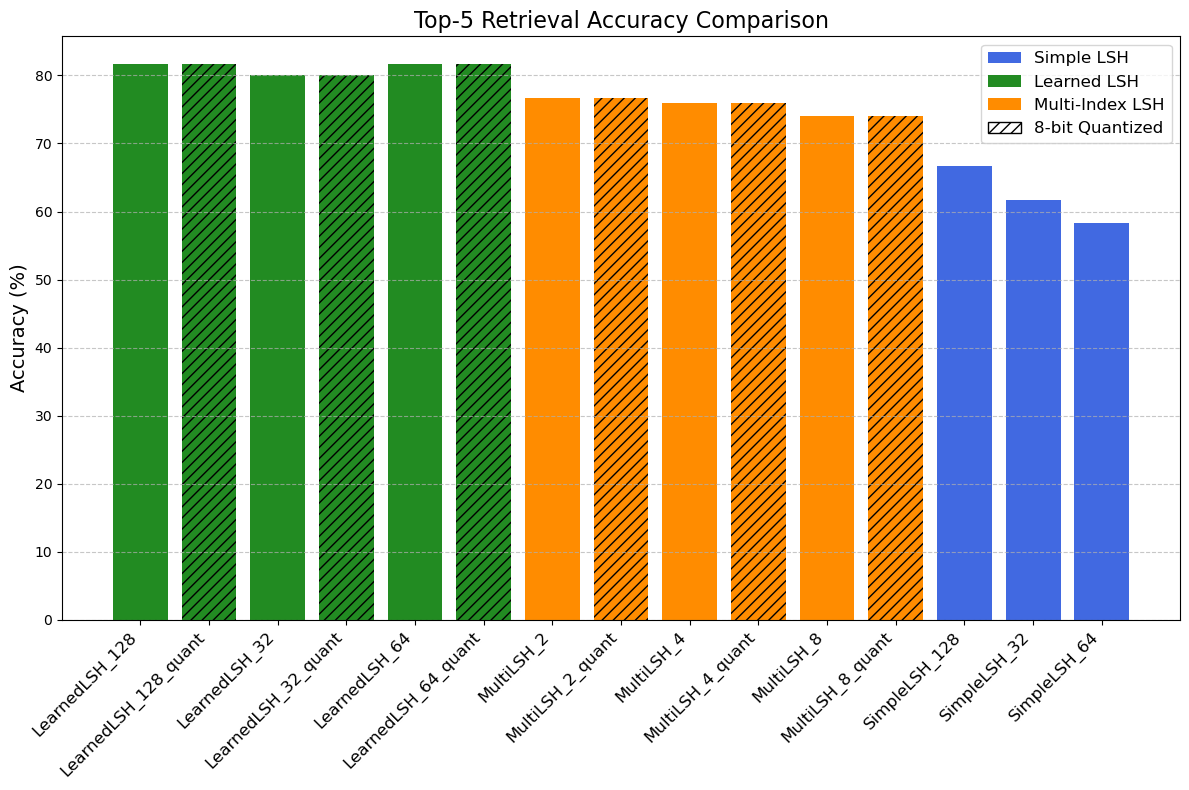

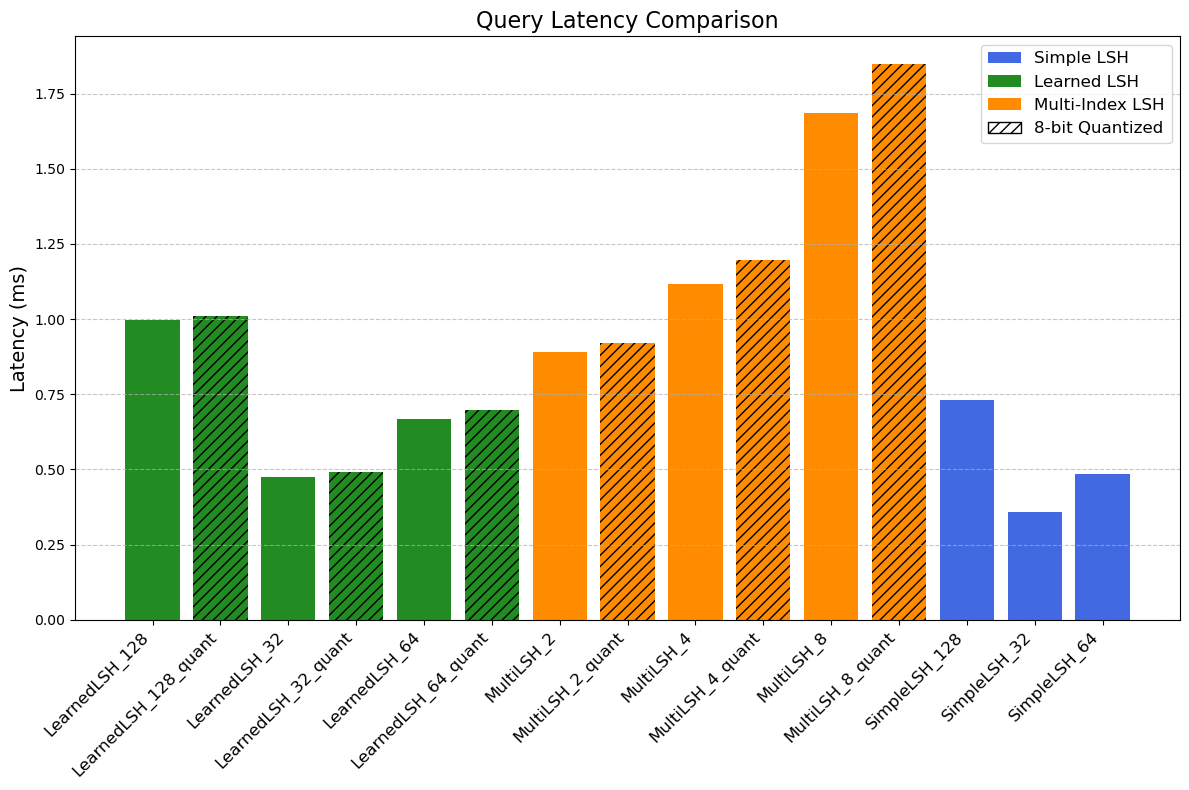

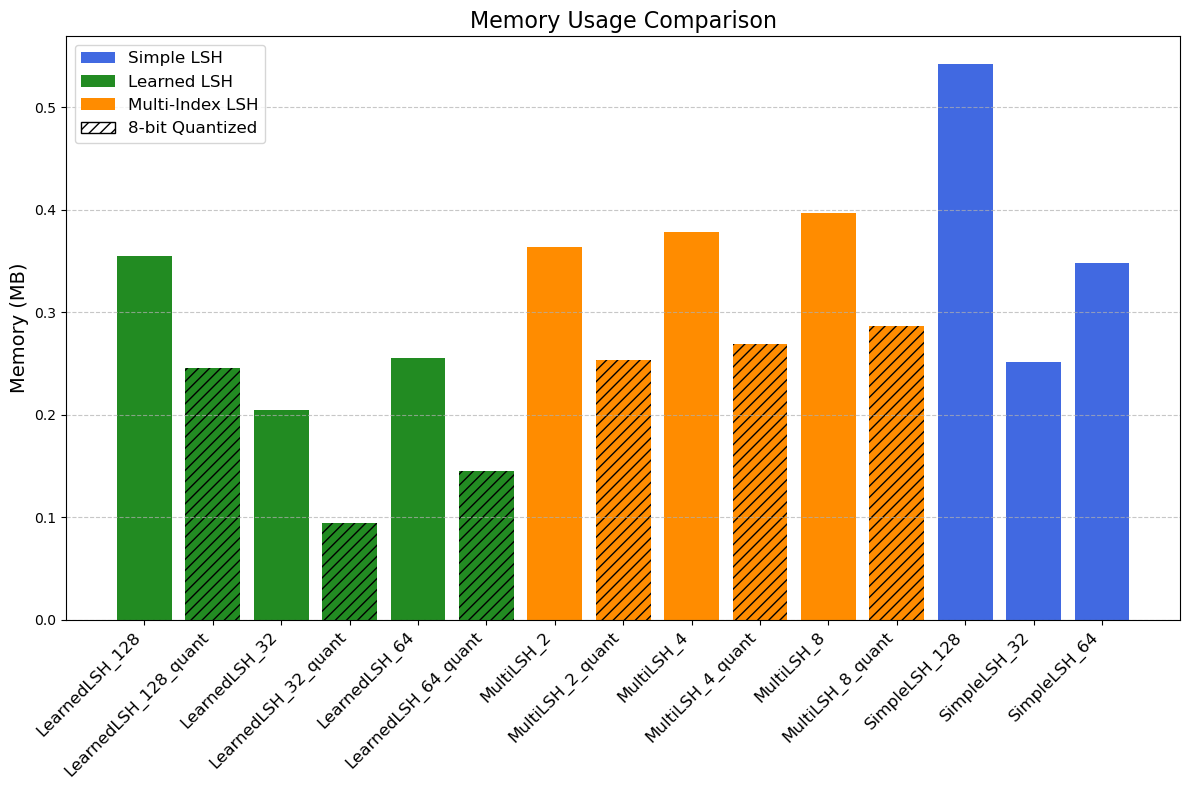

In [12]:
# Load AG News dataset
def load_and_prepare_data(train_size=10000, test_size=100):
    print("Loading AG News dataset...")
    ag_news_cats = {0: "World", 1: "Sports", 2: "Business", 3: "Science"}
    ag_dataset = load_dataset("ag_news", split="train").train_test_split(test_size=0.1)
    
    train_data = ag_dataset['train'].shuffle(seed=42).select(range(train_size))
    test_data = ag_dataset['test'].shuffle(seed=42).select(range(test_size))
    
    print(f"Loaded {len(train_data)} training samples and {len(test_data)} test samples")
    return train_data, test_data, ag_news_cats

# Run the main experiment
def run_experiment(train_data, test_data, model_name='all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu'):
    print(f"Using device: {device}")
    print(f"Loading SentenceTransformer model: {model_name}")
    st_model = SentenceTransformer(model_name, device=device)
    embed_dim = st_model.get_sentence_embedding_dimension()
    print(f"Embedding dimension: {embed_dim}")
    
    print("Creating triplet dataset...")
    triplet_dataset = ParagraphTripletDataset(train_data, model_name, device)
    dataloader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)
    
    hash_dimensions = [32, 64, 128]
    trained_hashers = {}
    
    for dim in hash_dimensions:
        print(f"Training hasher with dimension {dim}...")
        hasher = LearnedHasher(embed_dim, dim)
        trained_hasher = train(hasher, dataloader, epochs=2, lr=1e-3, device=device)
        trained_hashers[dim] = trained_hasher
    

    print("creating test embeddings...")
    test_texts = [item['text'] for item in test_data]
    test_labels = [item['label'] for item in test_data]
    test_embeddings = st_model.encode(test_texts, convert_to_tensor=True)
    

    print("init indexers...")
    indexers = {
        "SimpleLSH_32": SimpleLSHIndexer(32, embed_dim),
        "SimpleLSH_64": SimpleLSHIndexer(64, embed_dim),
        "SimpleLSH_128": SimpleLSHIndexer(128, embed_dim),
        "LearnedLSH_32": LSHIndexer(trained_hashers[32]),
        "LearnedLSH_64": LSHIndexer(trained_hashers[64]),
        "LearnedLSH_128": LSHIndexer(trained_hashers[128]),
        "LearnedLSH_32_quant": LSHIndexer(trained_hashers[32], quantize=True),
        "LearnedLSH_64_quant": LSHIndexer(trained_hashers[64], quantize=True),
        "LearnedLSH_128_quant": LSHIndexer(trained_hashers[128], quantize=True),
        "MultiLSH_2": MultiIndexLSHIndexer(trained_hashers[128], 2),
        "MultiLSH_4": MultiIndexLSHIndexer(trained_hashers[128], 4),
        "MultiLSH_8": MultiIndexLSHIndexer(trained_hashers[128], 8),
        "MultiLSH_2_quant": MultiIndexLSHIndexer(trained_hashers[128], 2, quantize=True),
        "MultiLSH_4_quant": MultiIndexLSHIndexer(trained_hashers[128], 4, quantize=True),
        "MultiLSH_8_quant": MultiIndexLSHIndexer(trained_hashers[128], 8, quantize=True),
    }
    
    print("indexing test embedds...")
    for name, indexer in indexers.items():
        print(f"Indexing with {name}...")
        for i, embedding in enumerate(test_embeddings):
            indexer.index(embedding, i)
    
    print("Core eval...")
    results = {}
    
    query_indices = random.sample(range(len(test_embeddings)), 20)
    neighbors_sizes = [1, 3, 5]
    
    for name, indexer in indexers.items():
        print(f"Evaluating {name}...")
        memory_usage = indexer.get_memory_usage_mb()
        
        for n_size in neighbors_sizes:
            key = f"{name}_n{n_size}"
            results[key] = {
                "accuracy": [],
                "latency": [],
                "memory_mb": memory_usage
            }
            
            for idx in query_indices:
                query_embedding = test_embeddings[idx]
                query_label = test_labels[idx]
                

                retrieved, query_time = indexer.query(query_embedding, top_k=5, neighbors=n_size)
                
                # calc accuracy 
                correct = sum(1 for doc_id, _ in retrieved if test_labels[doc_id] == query_label)
                accuracy = correct / len(retrieved) if retrieved else 0
                
                results[key]["accuracy"].append(accuracy)
                results[key]["latency"].append(query_time * 1000)  # Convert to ms
    
    summary = []
    for key, data in results.items():
        method, n_info = key.split("_n")
        avg_accuracy = np.mean(data["accuracy"]) * 100
        avg_latency = np.mean(data["latency"])
        memory = data["memory_mb"]
        
        summary.append({
            "Method": method,
            "Neighborhood": int(n_info),
            "Accuracy": avg_accuracy,
            "Latency_ms": avg_latency,
            "Memory_MB": memory
        })
    
    summary_df = pd.DataFrame(summary)
    return summary_df, results

# plotting functions
def plot_accuracy_comparison(summary_df):
    plt.figure(figsize=(12, 8))
    
    # Filter for n=3 for consistent comparison
    df = summary_df[summary_df["Neighborhood"] == 3].copy()
    
    # Sort by method name for better visualization
    df = df.sort_values("Method")
    
    method_types = {
        "SimpleLSH": "royalblue",
        "LearnedLSH": "forestgreen",
        "LearnedLSH_quant": "forestgreen",
        "MultiLSH": "darkorange",
        "MultiLSH_quant": "darkorange"
    }
    
    colors = []
    for method in df["Method"]:
        for key, color in method_types.items():
            if key in method:
                colors.append(color)
                break
        else:
            colors.append("gray")
    
    hatches = []
    for method in df["Method"]:
        if "quant" in method:
            hatches.append("///")
        else:
            hatches.append("")
    
    bars = plt.bar(df["Method"], df["Accuracy"], color=colors)
    
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    plt.title("Top-5 Retrieval Accuracy Comparison", fontsize=16)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="royalblue", label="Simple LSH"),
        Patch(facecolor="forestgreen", label="Learned LSH"),
        Patch(facecolor="darkorange", label="Multi-Index LSH"),
        Patch(facecolor="white", hatch="///", edgecolor="black", label="8-bit Quantized")
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    
    plt.tight_layout()
    return plt

def plot_latency_comparison(summary_df):
    plt.figure(figsize=(12, 8))
    
    df = summary_df[summary_df["Neighborhood"] == 3].copy()
    
    df = df.sort_values("Method")
    
    method_types = {
        "SimpleLSH": "royalblue",
        "LearnedLSH": "forestgreen",
        "LearnedLSH_quant": "forestgreen",
        "MultiLSH": "darkorange",
        "MultiLSH_quant": "darkorange",

    }
    
    colors = []
    for method in df["Method"]:
        for key, color in method_types.items():
            if key in method:
                colors.append(color)
                break
        else:
            colors.append("gray")
    
    hatches = []
    for method in df["Method"]:
        if "quant" in method:
            hatches.append("///")
        else:
            hatches.append("")
    
    bars = plt.bar(df["Method"], df["Latency_ms"], color=colors)
    
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    plt.title("Query Latency Comparison", fontsize=16)
    plt.ylabel("Latency (ms)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="royalblue", label="Simple LSH"),
        Patch(facecolor="forestgreen", label="Learned LSH"),
        Patch(facecolor="darkorange", label="Multi-Index LSH"),
        Patch(facecolor="white", hatch="///", edgecolor="black", label="8-bit Quantized")
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    
    plt.tight_layout()
    return plt

def plot_memory_comparison(summary_df):
    plt.figure(figsize=(12, 8))
    
    df = summary_df[summary_df["Neighborhood"] == 3].copy()
    df = df.drop_duplicates(subset=["Method"], keep="first")
    
    df = df.sort_values("Method")
    
    method_types = {
        "SimpleLSH": "royalblue",
        "LearnedLSH": "forestgreen",
        "LearnedLSH_quant": "forestgreen",
        "MultiLSH": "darkorange",
        "MultiLSH_quant": "darkorange",
    }
    
    colors = []
    for method in df["Method"]:
        for key, color in method_types.items():
            if key in method:
                colors.append(color)
                break
        else:
            colors.append("gray")
    
    hatches = []
    for method in df["Method"]:
        if "quant" in method:
            hatches.append("///")
        else:
            hatches.append("")
    
    bars = plt.bar(df["Method"], df["Memory_MB"], color=colors)
    
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    plt.title("Memory Usage Comparison", fontsize=16)
    plt.ylabel("Memory (MB)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="royalblue", label="Simple LSH"),
        Patch(facecolor="forestgreen", label="Learned LSH"),
        Patch(facecolor="darkorange", label="Multi-Index LSH"),
        Patch(facecolor="white", hatch="///", edgecolor="black", label="8-bit Quantized")
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    
    plt.tight_layout()
    return plt

def plot_neighborhood_effect(summary_df):
    plt.figure(figsize=(12, 8))
    
    methods = ["LearnedLSH_128", "MultiLSH_4"]
    
    # Prepare data
    data = []
    for method in methods:
        method_data = summary_df[summary_df["Method"] == method]
        for _, row in method_data.iterrows():
            data.append({
                "Method": method,
                "Neighborhood": row["Neighborhood"],
                "Accuracy": row["Accuracy"],
                "Latency_ms": row["Latency_ms"]
            })
    
    plot_df = pd.DataFrame(data)
    
    plt.subplot(1, 2, 1)
    for method in methods:
        method_data = plot_df[plot_df["Method"] == method]
        plt.plot(method_data["Neighborhood"], method_data["Accuracy"], 
                 marker='o', linestyle='-', linewidth=2, markersize=8, 
                 label=method)
    
    plt.title("Effect of Neighborhood Size on Accuracy", fontsize=14)
    plt.xlabel("Neighborhood Size", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for method in methods:
        method_data = plot_df[plot_df["Method"] == method]
        plt.plot(method_data["Neighborhood"], method_data["Latency_ms"], 
                 marker='o', linestyle='-', linewidth=2, markersize=8, 
                 label=method)
    
    plt.title("Effect of Neighborhood Size on Latency", fontsize=14)
    plt.xlabel("Neighborhood Size", fontsize=12)
    plt.ylabel("Latency (ms)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    return plt

def plot_hash_dimension_effect(summary_df):
    plt.figure(figsize=(12, 8))
    
    dimensions = [32, 64, 128]
    methods = []
    for dim in dimensions:
        methods.append(f"LearnedLSH_{dim}")
    df = summary_df[summary_df["Method"].isin(methods) & (summary_df["Neighborhood"] == 3)]
    
    df["Dimension"] = df["Method"].apply(lambda x: int(x.split("_")[1]))
    
    plt.subplot(1, 2, 1)
    plt.plot(df["Dimension"], df["Accuracy"], marker='o', linestyle='-', linewidth=2, markersize=10)
    plt.title("Effect of Hash Dimension on Accuracy", fontsize=14)
    plt.xlabel("Hash Dimension", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(dimensions)
    
    plt.subplot(1, 2, 2)
    plt.plot(df["Dimension"], df["Latency_ms"], marker='o', linestyle='-', linewidth=2, markersize=10)
    plt.title("Effect of Hash Dimension on Latency", fontsize=14)
    plt.xlabel("Hash Dimension", fontsize=12)
    plt.ylabel("Latency (ms)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(dimensions)
    
    plt.tight_layout()
    return plt


train_data, test_data, categories = load_and_prepare_data(train_size=1000, test_size=100)  # Use smaller samples for quick testing
summary_df, detailed_results = run_experiment(train_data, test_data)

accuracy_plot = plot_accuracy_comparison(summary_df)
accuracy_plot.savefig("accuracy_comparison.png")

latency_plot = plot_latency_comparison(summary_df)
latency_plot.savefig("latency_comparison.png")

memory_plot = plot_memory_comparison(summary_df)
memory_plot.savefig("memory_comparison.png")

In [13]:
print(summary_df)

                  Method  Neighborhood    Accuracy  Latency_ms  Memory_MB
0           SimpleLSH_32             1  100.000000    0.107861   0.251678
1           SimpleLSH_32             3   61.666667    0.359833   0.251678
2           SimpleLSH_32             5   49.000000    0.460994   0.251678
3           SimpleLSH_64             1  100.000000    0.119519   0.348480
4           SimpleLSH_64             3   58.333333    0.485802   0.348480
5           SimpleLSH_64             5   48.000000    0.585163   0.348480
6          SimpleLSH_128             1  100.000000    0.148356   0.542084
7          SimpleLSH_128             3   66.666667    0.731778   0.542084
8          SimpleLSH_128             5   60.000000    0.831056   0.542084
9          LearnedLSH_32             1  100.000000    0.269353   0.204529
10         LearnedLSH_32             3   80.000000    0.475943   0.204529
11         LearnedLSH_32             5   77.000000    0.482070   0.204529
12         LearnedLSH_64             1

### Experiment to measure scaling Performance

Encoding paragraphs...


Epoch 1/2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Loss: 0.5911


Epoch 2/2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Loss: 0.3197

Testing with dataset size: 100
Indexing with LearnedLSH_128
Indexing with MultiLSH_4
Indexing with LearnedLSH_128_quant
Indexing with MultiLSH_4_quant

Testing with dataset size: 1000
Indexing with LearnedLSH_128
Indexing with MultiLSH_4
Indexing with LearnedLSH_128_quant
Indexing with MultiLSH_4_quant

Testing with dataset size: 5000
Indexing with LearnedLSH_128
Indexing with MultiLSH_4
Indexing with LearnedLSH_128_quant
Indexing with MultiLSH_4_quant

Testing with dataset size: 10000
Indexing with LearnedLSH_128
Indexing with MultiLSH_4
Indexing with LearnedLSH_128_quant
Indexing with MultiLSH_4_quant

Testing with dataset size: 20000
Indexing with LearnedLSH_128
Indexing with MultiLSH_4
Indexing with LearnedLSH_128_quant
Indexing with MultiLSH_4_quant


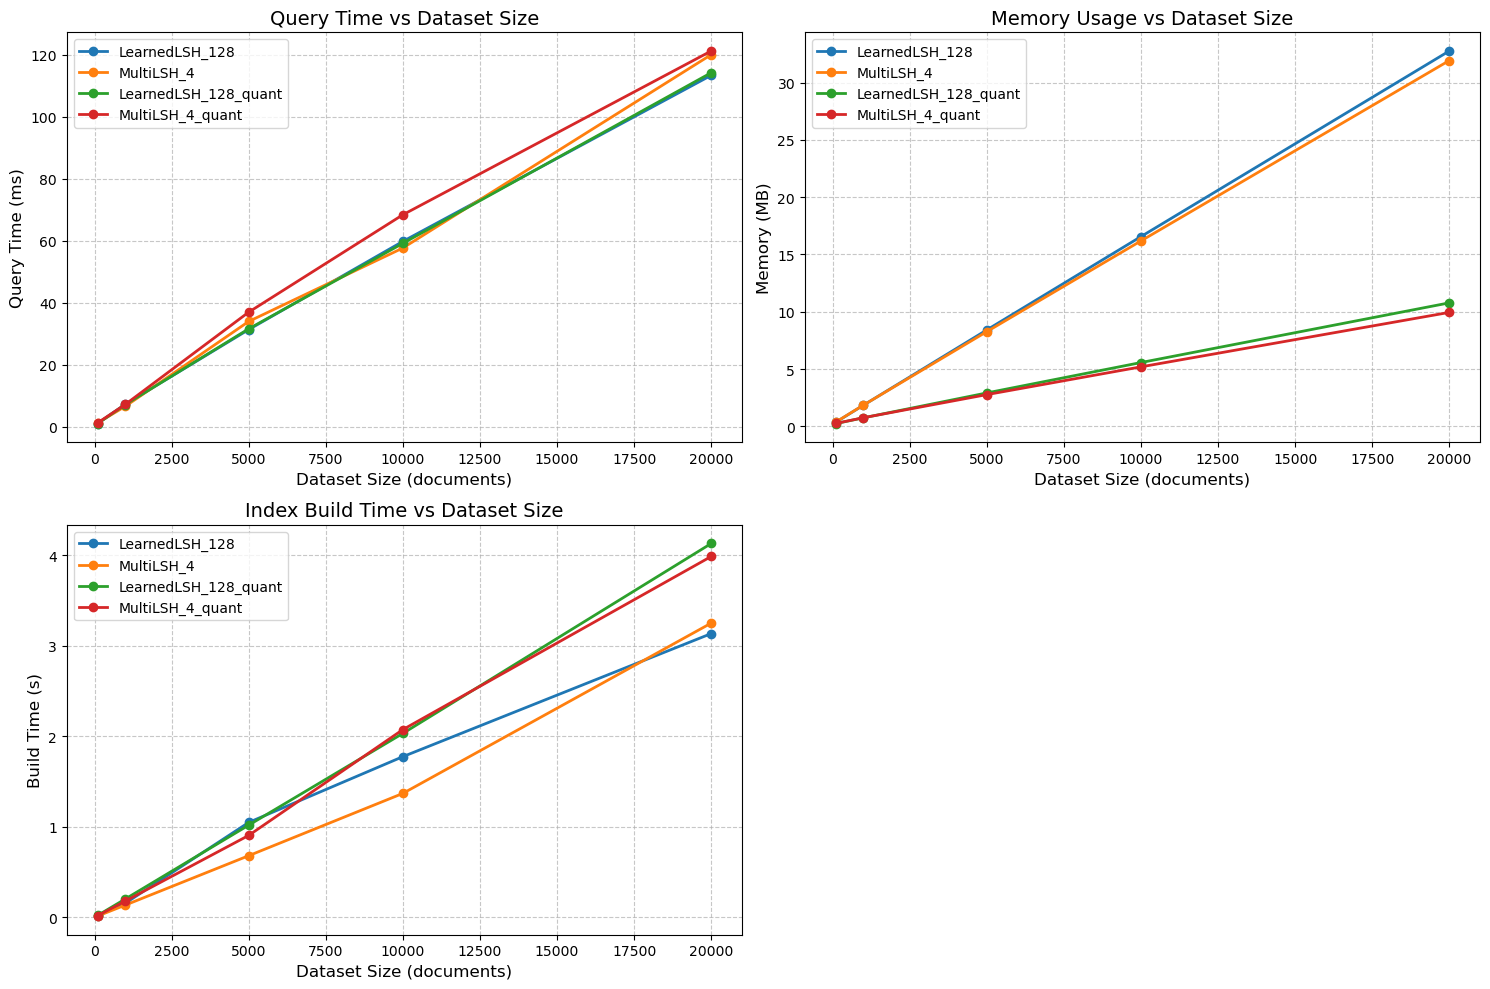

In [17]:
def test_scaling_performance(train_model=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_name = 'all-MiniLM-L6-v2'
    st_model = SentenceTransformer(model_name, device=device)
    embed_dim = st_model.get_sentence_embedding_dimension()
    
    # Load and prepare larger dataset
    dataset_sizes = [100, 1000, 5000, 10000, 20000]
    ag_dataset = load_dataset("ag_news", split="train")
    
    # Train or load hasher (only need to do once)
    hash_dim = 128
    hasher_path = f"hasher_{hash_dim}.pt"
    
    if train_model:
        train_subset = ag_dataset.shuffle(seed=42).select(range(5000))
        triplet_dataset = ParagraphTripletDataset(train_subset, model_name, device)
        dataloader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)
        
        hasher = LearnedHasher(embed_dim, hash_dim)
        trained_hasher = train(hasher, dataloader, epochs=2, device=device)
        torch.save(trained_hasher.state_dict(), hasher_path)
    else:
        hasher = LearnedHasher(embed_dim, hash_dim)
        hasher.load_state_dict(torch.load(hasher_path))
    
    results = []
    
    for size in dataset_sizes:
        print(f"\nTesting with dataset size: {size}")
        test_subset = ag_dataset.shuffle(seed=42).select(range(size))
        
        texts = [item['text'] for item in test_subset]
        all_embeddings = []
        
        batch_size = 128
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_embeddings = st_model.encode(batch_texts, convert_to_tensor=True)
            all_embeddings.append(batch_embeddings)
        
        embeddings = torch.cat(all_embeddings)
        
        indexers = {
            "LearnedLSH_128": LSHIndexer(hasher),
            "MultiLSH_4": MultiIndexLSHIndexer(hasher, 4),
            "LearnedLSH_128_quant": LSHIndexer(hasher, quantize=True),
            "MultiLSH_4_quant": MultiIndexLSHIndexer(hasher, 4, quantize=True)
        }
        
        # Index data
        for name, indexer in indexers.items():
            print(f"Indexing with {name}")
            start_time = time.time()
            for i, embedding in enumerate(embeddings):
                indexer.index(embedding, i)
            index_time = time.time() - start_time
            
            query_times = []
            query_indices = random.sample(range(len(embeddings)), min(20, len(embeddings)))
            
            for idx in query_indices:
                query_embedding = embeddings[idx]

                _, query_time = indexer.query(query_embedding, top_k=10, neighbors=3)
                
                query_times.append(query_time * 1000)  # convert to ms
            
            avg_query_time = np.mean(query_times)
            memory_usage = indexer.get_memory_usage_mb()
            
            results.append({
                "Method": name,
                "Dataset_Size": size, 
                "Index_Time_s": index_time,
                "Query_Time_ms": avg_query_time,
                "Memory_MB": memory_usage
            })
    
    return pd.DataFrame(results)

def plot_scaling_results(scaling_df):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for method in scaling_df["Method"].unique():
        data = scaling_df[scaling_df["Method"] == method]
        plt.plot(data["Dataset_Size"], data["Query_Time_ms"], 
                marker='o', linestyle='-', linewidth=2, label=method)
    
    plt.title("Query Time vs Dataset Size", fontsize=14)
    plt.xlabel("Dataset Size (documents)", fontsize=12)
    plt.ylabel("Query Time (ms)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.subplot(2, 2, 2)
    for method in scaling_df["Method"].unique():
        data = scaling_df[scaling_df["Method"] == method]
        plt.plot(data["Dataset_Size"], data["Memory_MB"], 
                marker='o', linestyle='-', linewidth=2, label=method)
    
    plt.title("Memory Usage vs Dataset Size", fontsize=14)
    plt.xlabel("Dataset Size (documents)", fontsize=12)
    plt.ylabel("Memory (MB)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    

    plt.subplot(2, 2, 3)
    for method in scaling_df["Method"].unique():
        data = scaling_df[scaling_df["Method"] == method]
        plt.plot(data["Dataset_Size"], data["Index_Time_s"], 
                marker='o', linestyle='-', linewidth=2, label=method)
    
    plt.title("Index Build Time vs Dataset Size", fontsize=14)
    plt.xlabel("Dataset Size (documents)", fontsize=12)
    plt.ylabel("Build Time (s)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    return plt

scaling_results = test_scaling_performance(train_model=True)  
scaling_plot = plot_scaling_results(scaling_results)
scaling_plot.savefig("scaling_comparison.png")

In [18]:
print(scaling_results)

                  Method  Dataset_Size  Index_Time_s  Query_Time_ms  Memory_MB
0         LearnedLSH_128           100      0.015599       1.025915   0.355072
1             MultiLSH_4           100      0.013636       1.230323   0.366463
2   LearnedLSH_128_quant           100      0.020441       1.041281   0.245209
3       MultiLSH_4_quant           100      0.018040       1.241755   0.256599
4         LearnedLSH_128          1000      0.156052       7.267594   1.847572
5             MultiLSH_4          1000      0.135276       6.595695   1.856293
6   LearnedLSH_128_quant          1000      0.202832       7.155573   0.748940
7       MultiLSH_4_quant          1000      0.179830       7.221317   0.757660
8         LearnedLSH_128          5000      1.048238      31.343019   8.412285
9             MultiLSH_4          5000      0.680720      33.966398   8.264793
10  LearnedLSH_128_quant          5000      1.018218      31.592047   2.919121
11      MultiLSH_4_quant          5000      0.904802

### Experiment to measure Query Complexity

encoding docs.
Indexing with LearnedLSH_128...
Indexing with MultiLSH_4...
Indexing with LearnedLSH_128_quant...
Indexing with MultiLSH_4_quant...
Testing Simple query: 'sports news'
Testing Medium query: 'latest sports news results football match'
Testing Complex query: 'comprehensive analysis of yesterday's championship football match results and team performance statistics'
Testing Very Complex query: 'detailed breakdown of the quarterly financial report showing growth trends and market analysis with projections for upcoming fiscal year'


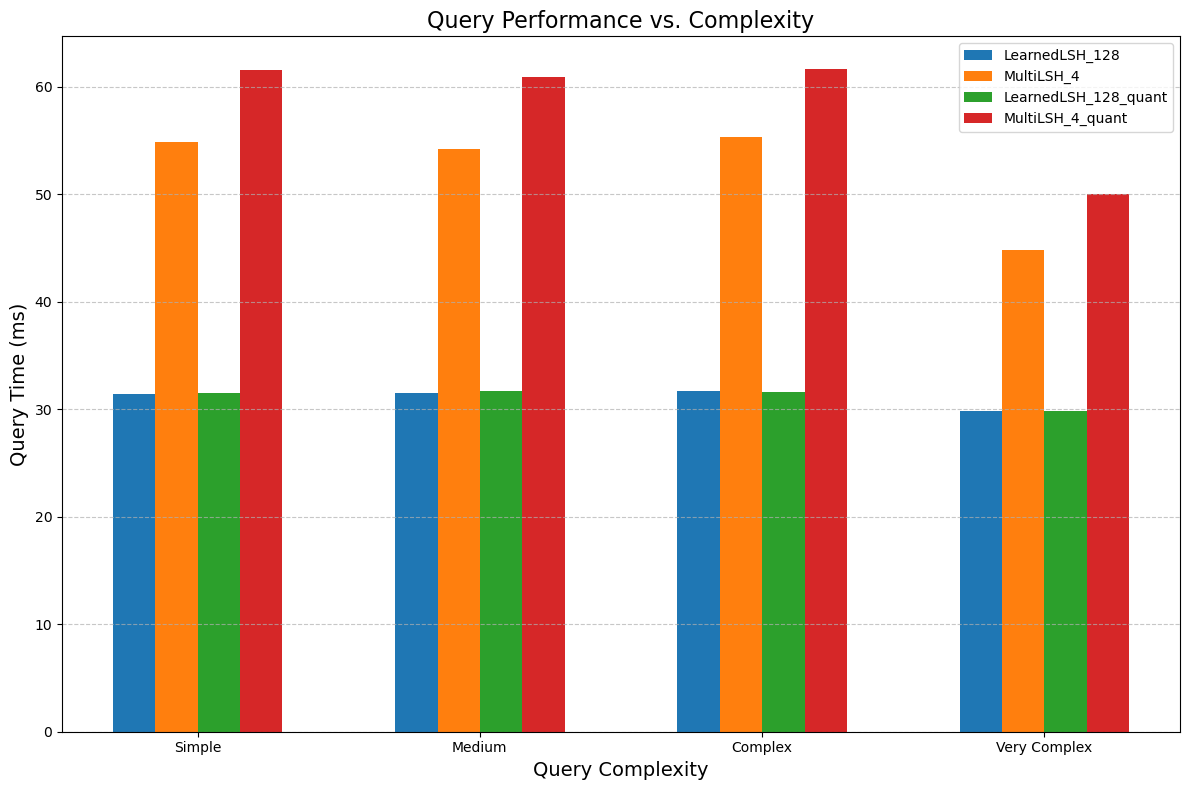

In [4]:
def test_query_complexity():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_name = 'all-MiniLM-L6-v2'
    st_model = SentenceTransformer(model_name,device=device)
    embed_dim = st_model.get_sentence_embedding_dimension()
    
    hash_dim = 128
    hasher_path = f"hasher_{hash_dim}.pt"
    hasher = LearnedHasher(embed_dim, hash_dim)
    hasher.load_state_dict(torch.load(hasher_path))
    hasher = hasher.to(device)
    
    indexers = {
        "LearnedLSH_128": LSHIndexer(hasher),
        "MultiLSH_4": MultiIndexLSHIndexer(hasher, 4),
        "LearnedLSH_128_quant": LSHIndexer(hasher, quantize=True),
        "MultiLSH_4_quant": MultiIndexLSHIndexer(hasher, 4, quantize=True)
    }
    
    dataset_size = 5000
    ag_dataset = load_dataset("ag_news", split="train").shuffle(seed=42).select(range(dataset_size))
    texts = [item['text'] for item in ag_dataset]
    
    print("encoding docs.")
    embeddings = []
    batch_size = 128
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = st_model.encode(batch_texts, convert_to_tensor=True)
        embeddings.append(batch_embeddings)
    
    embeddings = torch.cat(embeddings)
    for name, indexer in indexers.items():
        print(f"Indexing with {name}...")
        for i, embedding in enumerate(embeddings):
            indexer.index(embedding.to(device), i)
    
    query_texts = [
        "sports news",  # simple
        "latest sports news results football match",  # medium
        "comprehensive analysis of yesterday's championship football match results and team performance statistics",  # complex
        "detailed breakdown of the quarterly financial report showing growth trends and market analysis with projections for upcoming fiscal year"  # complex++
    ]
    
    query_complexities = ["Simple", "Medium", "Complex", "Very Complex"]
    
    results = []
    
    for i, query_text in enumerate(query_texts):
        complexity = query_complexities[i]
        print(f"Testing {complexity} query: '{query_text}'")
        query_embedding = st_model.encode(query_text, convert_to_tensor=True).to(device)
        
        for name, indexer in indexers.items():
            query_times = []
            for _ in range(10):
                _, query_time = indexer.query(query_embedding, top_k=10, neighbors=3)
                query_times.append(query_time * 1000)  # Convert to ms
            
            avg_query_time = np.mean(query_times)
            
            results.append({
                "Method": name,
                "Query_Complexity": complexity,
                "Query_Length": len(query_text.split()),
                "Query_Time_ms": avg_query_time
            })
    
    return pd.DataFrame(results)

def plot_query_complexity_results(complexity_df):
    plt.figure(figsize=(12, 8))
    
    methods = complexity_df["Method"].unique()
    complexities = ["Simple", "Medium", "Complex", "Very Complex"]
    
    width = 0.15
    x = np.arange(len(complexities))
    
    for i, method in enumerate(methods):
        data = complexity_df[complexity_df["Method"] == method]
        ordered_data = [data[data["Query_Complexity"] == c]["Query_Time_ms"].values[0] for c in complexities]
        
        plt.bar(x + i*width - (len(methods)-1)*width/2, ordered_data, width, label=method)
    
    plt.xlabel("Query Complexity", fontsize=14)
    plt.ylabel("Query Time (ms)", fontsize=14)
    plt.title("Query Performance vs. Complexity", fontsize=16)
    plt.xticks(x, complexities)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return plt

complexity_results = test_query_complexity()
complexity_plot = plot_query_complexity_results(complexity_results)
complexity_plot.savefig("query_complexity_comparison.png")

In [ ]:
!pip install seaborn

### Measure Recall

Generating recall plots...
Loading SentenceTransformer model: all-MiniLM-L6-v2
Embedding dimension: 384
creating triplet dataset...
Encoding paragraphs...
Training hasher with dimension 32...


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Loss: 0.9499


Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Loss: 0.8260
Training hasher with dimension 64...


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Loss: 0.9412


Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Loss: 0.7849
Training hasher with dimension 128...


Epoch 1/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Loss: 0.9203


Epoch 2/2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Loss: 0.7180
Indexing with SimpleLSH_32...
Indexing with SimpleLSH_64...
Indexing with SimpleLSH_128...
Indexing with LearnedLSH_32...
Indexing with LearnedLSH_64...
Indexing with LearnedLSH_128...
Indexing with LearnedLSH_32_quant...
Indexing with LearnedLSH_64_quant...
Indexing with LearnedLSH_128_quant...
Indexing with MultiLSH_2...
Indexing with MultiLSH_4...
Indexing with MultiLSH_8...
Indexing with MultiLSH_2_quant...
Indexing with MultiLSH_4_quant...
Indexing with MultiLSH_8_quant...
Evaluating recall ...


Evaluating recall:   0%|          | 0/15 [00:00<?, ?it/s]

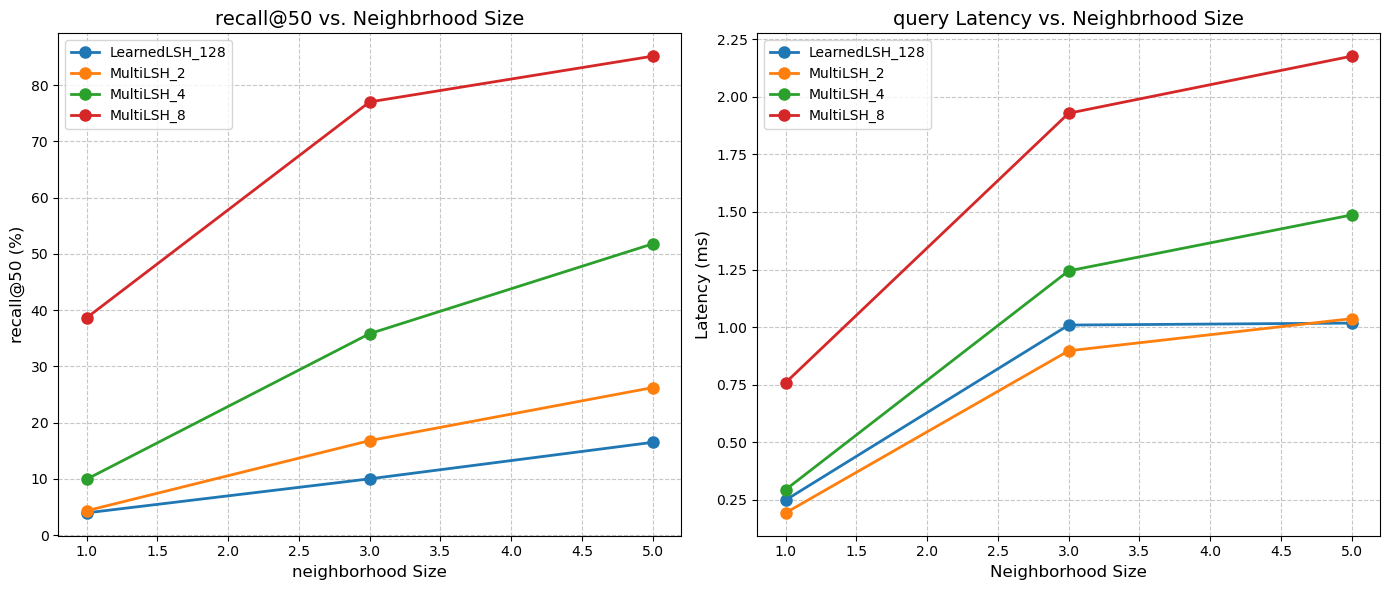

In [10]:
def calculate_recall(retrieved_ids, relevant_ids):
    if not relevant_ids:
        print("not relevant_ids")
        return 0.0
    
    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids)
    
    return len(retrieved_set.intersection(relevant_set)) / len(relevant_set)

def find_relevant_items(query_label, all_labels):
    return [i for i, label in enumerate(all_labels) if label == query_label]

def evaluate_recall_at_k(indexers, test_embeddings, test_labels, k_values=[5, 10, 20, 50, 100], neighbors_sizes=[1, 3, 5]):
    results = []
    query_indices = random.sample(range(len(test_embeddings)), 20)
    
    for name, indexer in tqdm(indexers.items(), desc="Evaluating recall"):
        for n_size in neighbors_sizes:
            for k in k_values:
                recalls = []
                latencies = []
                
                for idx in query_indices:
                    query_embedding = test_embeddings[idx]
                    query_label = test_labels[idx]
                    relevant_ids = find_relevant_items(query_label, test_labels)
                    #print(relevant_ids)

                    retrieved, query_time = indexer.query(query_embedding, top_k=k, neighbors=n_size)
                    retrieved_ids = [doc_id for doc_id, _ in retrieved]
                    recall = calculate_recall(retrieved_ids, relevant_ids)
                    recalls.append(recall)
                    latencies.append(query_time * 1000)  # Convert to ms
                
                results.append({
                    "Method": name,
                    "Neighborhood": n_size,
                    "K": k,
                    "Recall": np.mean(recalls) * 100,  # To percentage
                    "Latency_ms": np.mean(latencies)
                })
    
    return pd.DataFrame(results)

def plot_multi_index_comparison(recall_df):
    multi_methods = ["LearnedLSH_128", "MultiLSH_2", "MultiLSH_4", "MultiLSH_8"]
    df = recall_df[(recall_df["Method"].isin(multi_methods)) & (recall_df["K"] == 50)]
    
    plt.figure(figsize=(14, 6))
    

    plt.subplot(1, 2, 1)     # recall vs. neighbrood size
    for method in multi_methods:
        method_data = df[df["Method"] == method]
        plt.plot(method_data["Neighborhood"], method_data["Recall"],
                marker='o', linestyle='-', linewidth=2, markersize=8,
                label=method)
    
    plt.title("recall@50 vs. Neighbrhood Size", fontsize=14)
    plt.xlabel("neighborhood Size", fontsize=12)
    plt.ylabel("recall@50 (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    
    plt.subplot(1, 2, 2) # latency vs. neighbrood size
    for method in multi_methods:
        method_data = df[df["Method"] == method]
        plt.plot(method_data["Neighborhood"], method_data["Latency_ms"],
                marker='o', linestyle='-', linewidth=2, markersize=8,
                label=method)
    
    plt.title("query Latency vs. Neighbrhood Size", fontsize=14)
    plt.xlabel("Neighborhood Size", fontsize=12)
    plt.ylabel("Latency (ms)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.tight_layout()
    return plt

def test_recall():
    model_name='all-MiniLM-L6-v2'
    device='cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Loading SentenceTransformer model: {model_name}")
    st_model = SentenceTransformer(model_name,device=device)
    embed_dim = st_model.get_sentence_embedding_dimension()
    print(f"Embedding dimension: {embed_dim}")
    
    # create dataset and dataloader for training hasher
    print("creating triplet dataset...")
    triplet_dataset = ParagraphTripletDataset(train_data, model_name, device)
    dataloader = DataLoader(triplet_dataset, batch_size=64, shuffle=True)
    
    #different dimensions
    hash_dimensions = [32, 64, 128]
    trained_hashers = {}
    
    for dim in hash_dimensions:
        print(f"Training hasher with dimension {dim}...")
        hasher = LearnedHasher(embed_dim, dim)
        trained_hasher = train(hasher, dataloader, epochs=2, lr=1e-3, device=device)
        trained_hashers[dim] = trained_hasher
    
    test_texts = [item['text'] for item in test_data]
    test_labels = [item['label'] for item in test_data]
    test_embeddings = st_model.encode(test_texts, convert_to_tensor=True)
    

    indexers = {
        "SimpleLSH_32": SimpleLSHIndexer(32, embed_dim),
        "SimpleLSH_64": SimpleLSHIndexer(64, embed_dim),
        "SimpleLSH_128": SimpleLSHIndexer(128, embed_dim),
        "LearnedLSH_32": LSHIndexer(trained_hashers[32]),
        "LearnedLSH_64": LSHIndexer(trained_hashers[64]),
        "LearnedLSH_128": LSHIndexer(trained_hashers[128]),
        "LearnedLSH_32_quant": LSHIndexer(trained_hashers[32], quantize=True),
        "LearnedLSH_64_quant": LSHIndexer(trained_hashers[64], quantize=True),
        "LearnedLSH_128_quant": LSHIndexer(trained_hashers[128], quantize=True),
        "MultiLSH_2": MultiIndexLSHIndexer(trained_hashers[128], 2),
        "MultiLSH_4": MultiIndexLSHIndexer(trained_hashers[128], 4),
        "MultiLSH_8": MultiIndexLSHIndexer(trained_hashers[128], 8),
        "MultiLSH_2_quant": MultiIndexLSHIndexer(trained_hashers[128], 2, quantize=True),
        "MultiLSH_4_quant": MultiIndexLSHIndexer(trained_hashers[128], 4, quantize=True),
        "MultiLSH_8_quant": MultiIndexLSHIndexer(trained_hashers[128], 8, quantize=True),
    }
    
    for name, indexer in indexers.items():
        print(f"Indexing with {name}...")
        for i, embedding in enumerate(test_embeddings):
            indexer.index(embedding, i)
    
    print("Evaluating recall ...")
    recall_df = evaluate_recall_at_k(indexers, test_embeddings, test_labels)
    
    recall_df.to_csv("lsh_recall_results.csv", index=False)
    return recall_df

# Generate recall plots
print("Generating recall plots...")
recall_df = test_recall()
multi_index_comparison_plot = plot_multi_index_comparison(recall_df)
multi_index_comparison_plot.savefig("multi_index_comparison.png")

In [16]:
multi_methods = ["LearnedLSH_128", "MultiLSH_2", "MultiLSH_4", "MultiLSH_8"]
df = recall_df[(recall_df["Method"].isin(multi_methods)) & (recall_df["K"] == 50)]

print(df)

             Method  Neighborhood   K     Recall  Latency_ms
78   LearnedLSH_128             1  50   3.971014    0.248456
83   LearnedLSH_128             3  50  10.024960    1.008773
88   LearnedLSH_128             5  50  16.514090    1.017284
138      MultiLSH_2             1  50   4.341385    0.193012
143      MultiLSH_2             3  50  16.819646    0.896859
148      MultiLSH_2             5  50  26.243156    1.036656
153      MultiLSH_4             1  50   9.946457    0.293624
158      MultiLSH_4             3  50  35.828905    1.244128
163      MultiLSH_4             5  50  51.796699    1.486921
168      MultiLSH_8             1  50  38.636473    0.758278
173      MultiLSH_8             3  50  77.026167    1.928604
178      MultiLSH_8             5  50  85.161433    2.176476
